In [1]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Features
from rdkit.Chem import Fragments
from rdkit.Chem import rdMolDescriptors
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
#Loading the datasets
datasets = dc.molnet.load_tox21()

[15:16:11] WARNING: not removing hydrogen atom without neighbors
[15:16:18] WARNING: not removing hydrogen atom without neighbors


In [4]:
tasks, datasets, transformers = datasets

In [5]:
#Transforming dataset into a pandas dataframe
train_dataset, valid_dataset, test_dataset = datasets

train_df = train_dataset.to_dataframe()
test_dataset = test_dataset.to_dataframe()
valid_dataset = valid_dataset.to_dataframe()

#This line concatenates all the dataframes, we will resplit them later with SKLEARN
dataset = pd.concat([train_df, test_dataset, valid_dataset])

dataset

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,w4,w5,w6,w7,w8,w9,w10,w11,w12,ids
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045415,1.146078,1.056211,1.025552,1.172679,1.035385,1.055765,1.174650,1.052884,CC(O)(P(=O)(O)O)P(=O)(O)O
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045415,1.146078,1.056211,1.025552,0.000000,1.035385,1.055765,1.174650,1.052884,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045415,1.146078,1.056211,1.025552,1.172679,1.035385,1.055765,0.000000,1.052884,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.172679,0.000000,1.055765,0.000000,0.000000,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045415,1.146078,1.056211,1.025552,1.172679,1.035385,1.055765,1.174650,1.052884,CC(C)COC(=O)C(C)C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.146078,1.056211,0.000000,0.000000,0.000000,0.000000,6.725738,19.909420,N#CC(c1ccc(Cl)cc1)c1c(Cl)cc(-n2ncc(=O)[nH]c2=O...
779,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.045415,1.146078,1.056211,1.025552,1.172679,1.035385,1.055765,0.000000,1.052884,CN1CC(=O)N2[C@H](Cc3c([nH]c4ccccc34)[C@H]2c2cc...
780,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.045415,1.146078,1.056211,1.025552,0.000000,1.035385,0.000000,0.000000,1.052884,O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1
781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,7.845679,18.790000,1.025552,0.000000,1.035385,0.000000,1.174650,1.052884,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...


In [7]:
#Selecting only the SMILES and y1-y7 columns

dataset = dataset[['ids', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]

#Adding two columns, the first will sum all toxicity values
#The second will be a binary classification of if it is toxic or not depending on if tox is >0


In [8]:
dataset

,ids,y1,y2,y3,y4,y5,y6,y7
0,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OC[C@H](O)[C@@H](O)[C@H](O)CO,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(C)COC(=O)C(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
778,N#CC(c1ccc(Cl)cc1)c1c(Cl)cc(-n2ncc(=O)[nH]c2=O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,CN1CC(=O)N2[C@H](Cc3c([nH]c4ccccc34)[C@H]2c2cc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780,O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
781,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [14]:
import re
from rdkit.Chem import Fragments as fr

#Get all the possible functions within the fr(fragments) module and put them into a list
#This is called a list comprehension it says 'for each element in this list, do this'
#E.g for each name in the directory of the fr module, if the function is callable (i.e. it has a value) then append it to the list
function_names = [name for name in dir(fr) if callable(getattr(fr, name))]
function_names.pop(0)
function_names.pop(0)

'_LoadPatterns'

In [15]:
function_names

['fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_Nhpyrrole',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amide',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_barbitur',
 'fr_benzene',
 'fr_benzodiazepine',
 'fr_bicyclic',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_halogen',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactam',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitrile',
 'fr_nitro',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_nitroso',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',

In [24]:
#Iterate through the rows in the dataframe
# For each row, create a molecule object from the smiles strings
# For each function in the list of functions, get the value for that function (in this case the total number of each functional group)
#Then add that value to the dataframe for that row with the column heading as the name of the function

for index, row in dataset.iterrows():
    mol = Chem.MolFromSmiles(row['ids']) # Create molecule object
    for function in function_names: # For each function in functions
        dataset.at[index, function] = np.where(getattr(fr, function)(mol) == 0, 0, 1)


[16:24:25] WARNING: not removing hydrogen atom without neighbors


In [25]:
dataset

,ids,y1,y2,y3,y4,y5,y6,y7,fr_Al_COO,fr_Al_OH,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,tox_bin
0,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,OC[C@H](O)[C@@H](O)[C@H](O)CO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,CC(C)COC(=O)C(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,N#CC(c1ccc(Cl)cc1)c1c(Cl)cc(-n2ncc(=O)[nH]c2=O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
779,CN1CC(=O)N2[C@H](Cc3c([nH]c4ccccc34)[C@H]2c2cc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
781,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [26]:
# Lets add up all the y values into one 'toxicity measure
col_to_sum = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']

#This adds a new column called 'tox' which is the sum of each row 
dataset['tox'] = dataset[col_to_sum].sum(axis=1)

#Lets add another row with a binary (1 or 0) that tells us if the compound is toxic against one or more of the assays or not
dataset['tox_bin'] = dataset['tox'].apply(lambda x: 1 if x>0 else 0)
dataset.drop(columns=['tox'], inplace=True)
dataset


,ids,y1,y2,y3,y4,y5,y6,y7,fr_Al_COO,fr_Al_OH,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,tox_bin
0,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,OC[C@H](O)[C@@H](O)[C@H](O)CO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,CC(C)COC(=O)C(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,N#CC(c1ccc(Cl)cc1)c1c(Cl)cc(-n2ncc(=O)[nH]c2=O...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
779,CN1CC(=O)N2[C@H](Cc3c([nH]c4ccccc34)[C@H]2c2cc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
781,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [27]:
func_groups = function_names
total_tox_groups = {}

for group in func_groups:
    group_frequency_tox = dataset[dataset['tox_bin'] == 1][group].value_counts()
    group_frequency_total = dataset[group].value_counts()
    total_tox_groups[group] = (group_frequency_tox, group_frequency_total)


In [46]:
total_tox_groups['fr_Al_COO']

(fr_Al_COO
 0.0    1754
 1.0     158
 Name: count, dtype: int64,
 fr_Al_COO
 0.0    7128
 1.0     703
 Name: count, dtype: int64)

In [59]:
total_tox_groups_df = pd.DataFrame(columns=['tox_with', 'tox_without', 'total_with', 'total_without'])

total_tox_groups_df

,tox_with,tox_without,total_with,total_without


In [60]:


for key, value in total_tox_groups.items():
    tox = value[0]
    total = value[1]

    if 0.0 not in tox:
        tox[0.0] = 0
    
    if 1.0 not in tox:
        tox[1.0] = 0
    
    if 0.0 not in total:
        total[0.0] = 0
    
    if 1.0 not in total:
        total[1.0] = 0
    
    tox_with = tox[1.0]
    tox_without = tox[0.0]
    
    total_with = total[1.0]
    total_without = total[0.0]

    data = { 
            'tox_with': tox_with, 
            'tox_without': tox_without, 
            'total_with': total_with, 
            'total_without': total_without}
    
    total_tox_groups_df = pd.concat([total_tox_groups_df, pd.DataFrame(data, index=[key])], axis=0)

In [61]:
total_tox_groups_df

,tox_with,tox_without,total_with,total_without
fr_Al_COO,158,1754,703,7128
fr_Al_OH,341,1571,1387,6444
fr_Al_OH_noTert,277,1635,1153,6678
fr_ArN,189,1723,531,7300
fr_Ar_COO,67,1845,300,7531
...,...,...,...,...
fr_thiazole,52,1860,134,7697
fr_thiocyan,3,1909,9,7822
fr_thiophene,25,1887,108,7723
fr_unbrch_alkane,173,1739,871,6960


In [63]:
total_tox_groups_df['proportion of toxic with FG'] = total_tox_groups_df['tox_with']/(total_tox_groups_df['tox_with'] + total_tox_groups_df['tox_without'])
total_tox_groups_df['proportion of total with FG'] = total_tox_groups_df['total_with']/(total_tox_groups_df['total_with'] + total_tox_groups_df['total_without'])

total_tox_groups_df

,tox_with,tox_without,total_with,total_without,proportion of toxic with FG,proportion of total with FG
fr_Al_COO,158,1754,703,7128,0.082636,0.089771
fr_Al_OH,341,1571,1387,6444,0.178347,0.177117
fr_Al_OH_noTert,277,1635,1153,6678,0.144874,0.147235
fr_ArN,189,1723,531,7300,0.098849,0.067807
fr_Ar_COO,67,1845,300,7531,0.035042,0.038309
...,...,...,...,...,...,...
fr_thiazole,52,1860,134,7697,0.027197,0.017111
fr_thiocyan,3,1909,9,7822,0.001569,0.001149
fr_thiophene,25,1887,108,7723,0.013075,0.013791
fr_unbrch_alkane,173,1739,871,6960,0.090481,0.111225


In [65]:
total_tox_groups_df_sorted = total_tox_groups_df.sort_values(by='proportion of toxic with FG', ascending=False)
total_tox_groups_df_sorted

,tox_with,tox_without,total_with,total_without,proportion of toxic with FG,proportion of total with FG
fr_benzene,1374,538,4965,2866,0.718619,0.634019
fr_C_O,1040,872,4145,3686,0.543933,0.529307
fr_C_O_noCOO,929,983,3663,4168,0.485879,0.467756
fr_NH0,877,1035,3815,4016,0.458682,0.487166
fr_bicyclic,771,1141,2426,5405,0.403243,0.309794
...,...,...,...,...,...,...
fr_isothiocyan,2,1910,6,7825,0.001046,0.000766
fr_azide,1,1911,2,7829,0.000523,0.000255
fr_barbitur,1,1911,17,7814,0.000523,0.002171
fr_prisulfonamd,0,1912,0,7831,0.0,0.0


(-1.0, 85.0)

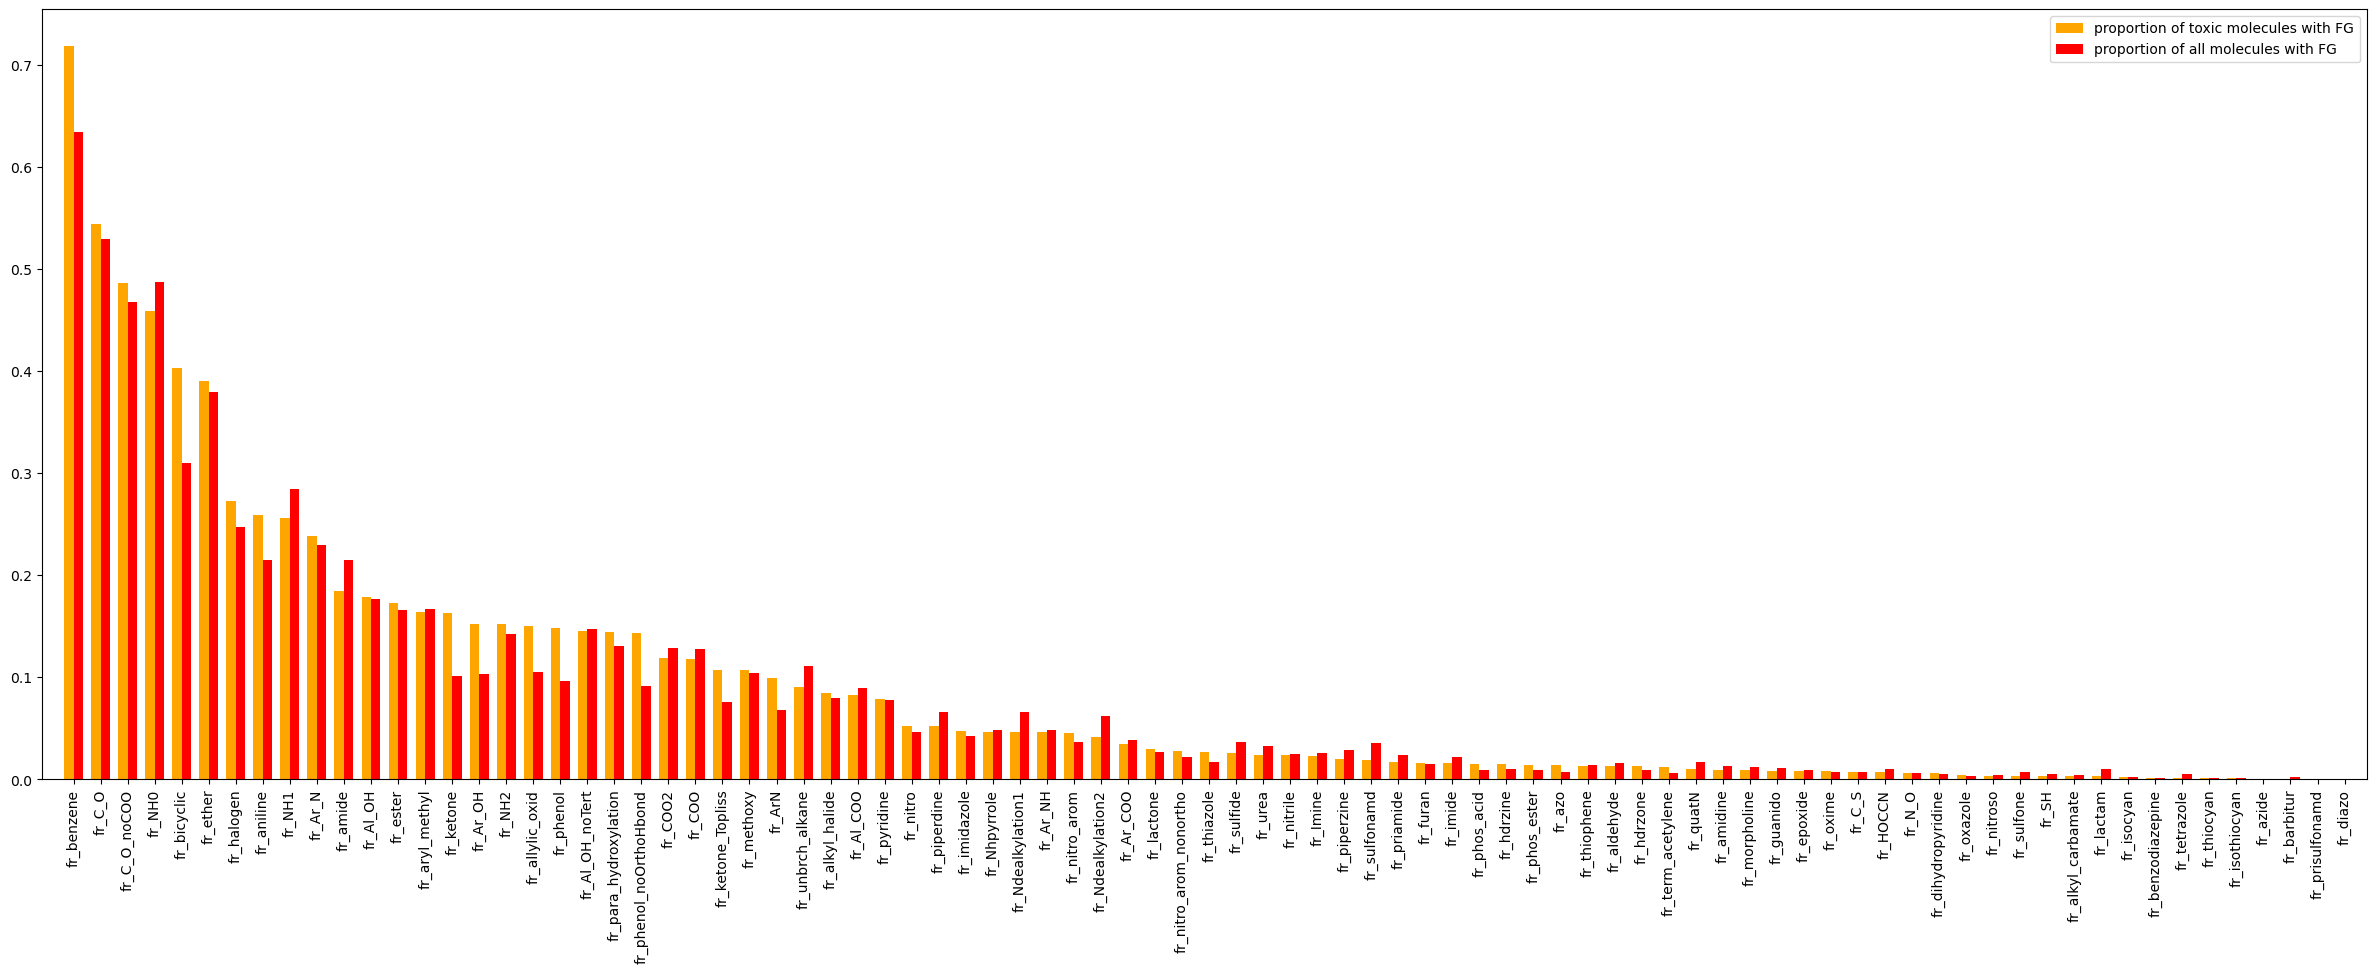

In [92]:
plt.figure(figsize=(30, 10))

# Set the width of each bar
bar_width = 0.35

r1 = np.arange(len(total_tox_groups_df_sorted))
r2 = [x + bar_width for x in r1]

plt.xticks([r + bar_width / 2 for r in range(len(total_tox_groups_df_sorted))], total_tox_groups_df_sorted.index)

plt.bar(r1, total_tox_groups_df_sorted['proportion of toxic with FG'], label = 'proportion of toxic molecules with FG', color='orange', width=bar_width)
plt.bar(r2, total_tox_groups_df_sorted['proportion of total with FG'], label = 'proportion of all molecules with FG', color='red', width=bar_width)

lab = plt.xticks(rotation=90)
plt.legend()

plt.xlim(-1, len(total_tox_groups_df_sorted))

(-1.0, 85.0)

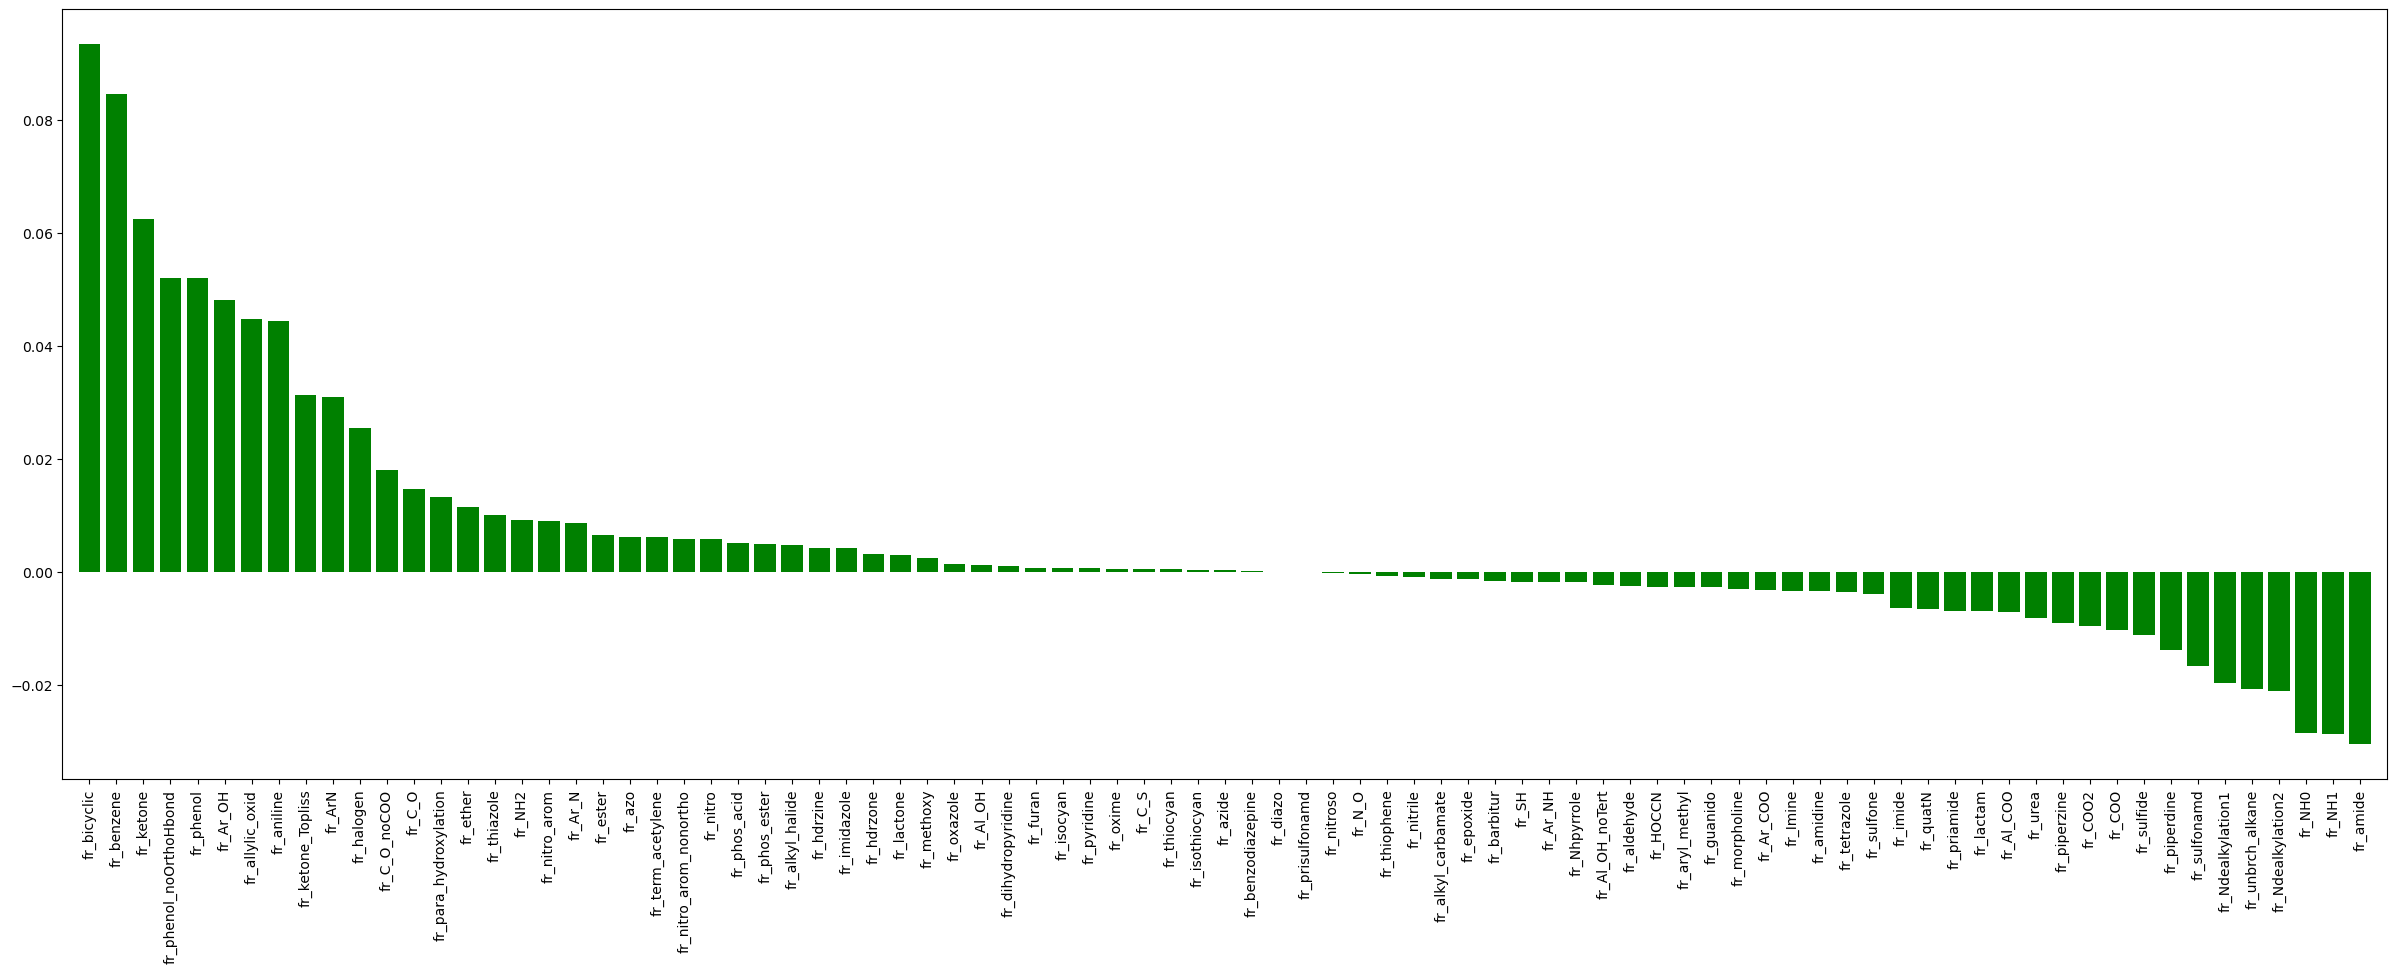

In [97]:
residuals = total_tox_groups_df_sorted['proportion of toxic with FG'] - total_tox_groups_df_sorted['proportion of total with FG']

total_tox_groups_df_sorted['residuals'] = residuals

total_tox_groups_df_res_sorted = total_tox_groups_df_sorted.sort_values(by='residuals', ascending=False)

plt.figure(figsize=(30, 10))
plt.bar(total_tox_groups_df_res_sorted.index, total_tox_groups_df_res_sorted['residuals'], color='green')
lab =plt.xticks(rotation=90)
plt.xlim(-1, len(total_tox_groups_df_sorted))